In [2]:
import os
import glob
import numpy as np
import pandas as pd

import openslide
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt 


import sys
sys.path.append("/scratch_tmp/users/k21066795/NBT-Classifier")
from utils import *

### Load WSI & foreground tissue mask

In [5]:
wsi_pt = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/KHP_RM/17064108_FPE_1.ndpi'
mask_pt = '/scratch_tmp/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSI_QC/KHP_RM/17064108_FPE_1.ndpi/17064108_FPE_1.ndpi_mask_use.png'

579


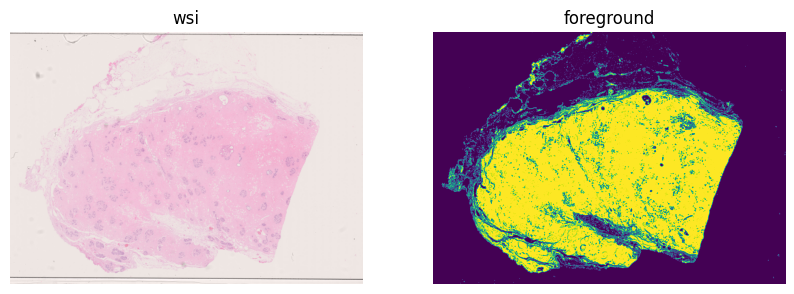

In [3]:
wsi = openslide.OpenSlide(wsi_pt)
im_wsi = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
im_mask = Image.open(mask_pt)
plot_oneline([im_wsi, im_mask], ['wsi', 'foreground'], (10,10))

### Whole slide tissue classification

In [ ]:
weights = '/scratch_tmp/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/ckpts/Tissue_Classifier.h5'
TC = get_TC(weights)
save_folder = "/scratch_tmp/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/"

In [12]:
tissue_map = run_TC_one_slide(wsi, mask_pt, TC, output_pattern, patch_size=128, foreground_thes=0.7, mrxs=False)

/tmp/ipykernel_391280/3858112497.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  tc_predictions = TC.predict_generator(generator=wsi_sequence, steps=len(wsi_sequence),verbose=1)


2345/2345 [==============================] - 32s 14ms/step


### Whole slide tissue class heatmaps

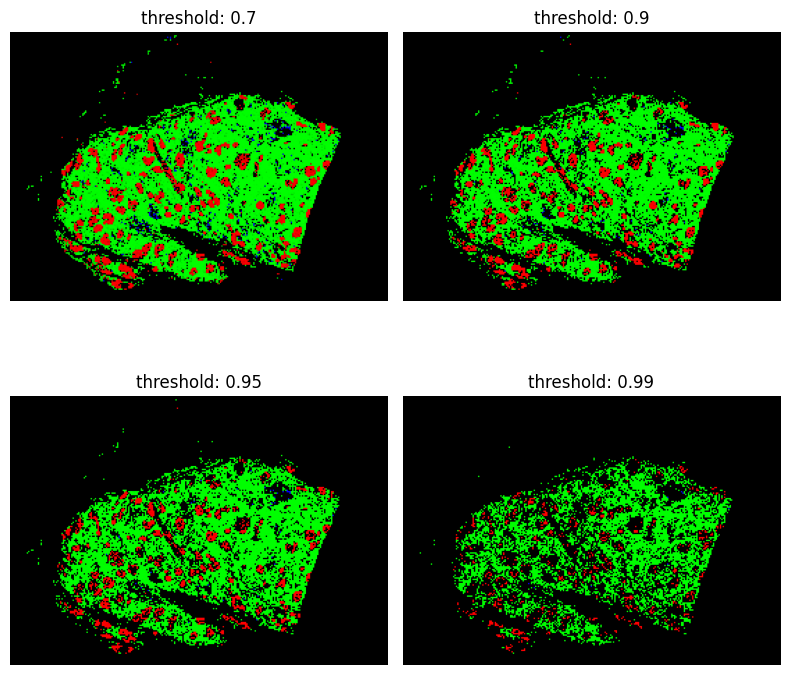

In [14]:
images = []
thresholds = [0.7, 0.9, 0.95, 0.99]
for threshold in thresholds:
    im = tissue_map.copy()
    im[:,:, 0][tissue_map[:,:, 0] < threshold] = 0
    im[:,:, 1][tissue_map[:,:, 1] < threshold] = 0
    im[:,:, 2][tissue_map[:,:, 2] < threshold] = 0
    images.append(im)


fig, axs = plt.subplots(2, 2, figsize=(8, 8))
counter = 0
for x in range(2):
    for y in range(2):
        axs[x, y].imshow(images[counter])
        axs[x, y].set_title(f'threshold: {thresholds[counter]}')
        axs[x, y].axis('off') 
        counter += 1
plt.tight_layout()
plt.show()

### Converting to JSON Format for QuPath Compatibility

In [18]:
cls_dict = {'epithelium': 0, 'stroma':1, 'adipocytes':2, 'background': 3}
json_pt = f"{save_folder}17064108_FPE_1_TC512.json"

In [19]:
TC_cls = tissue_map.copy()
TC_cls = np.argmax(TC_cls, axis=2)
TC_cls[tissue_map[:,:,0]==0] = 3

patch_size, _ = parse_patch_size(wsi, patch_size=128)
print(patch_size)

cls_df = {'orig_x': [], 'orig_y': [], 'cls': []}
for x in range(TC_cls.shape[1]):
    for y in range(TC_cls.shape[0]):
        cls_df['orig_x'].append(int(x * patch_size))
        cls_df['orig_y'].append(int(y * patch_size))
        cls_df['cls'].append(TC_cls[y, x])
cls_df = pd.DataFrame.from_dict(cls_df)
cls_df = cls_df.loc[cls_df['cls']!=3, ]

get_JSON(cls_df, cls_dict, json_pt, patch_size, require_bounds=False)

579
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/17064108_FPE_1_TC512.json saved!


## Lobule binary mask

In [32]:
level = 4
small_objects=400000
threshold = 0.7
TC_maskpt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_TCprobmask.npy'

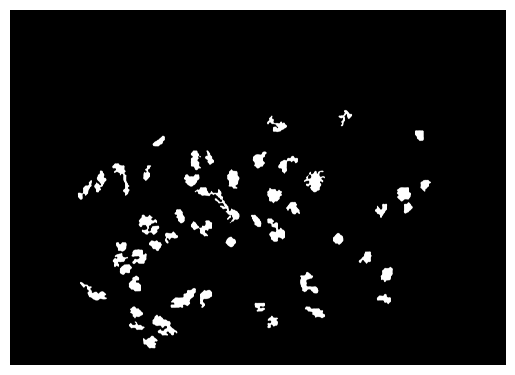

In [33]:
wsi_mask_ratio = wsi.level_downsamples[level]
small_objects = small_objects / wsi_mask_ratio
epi_mask = process_TCmask(wsi_pt, TC_maskpt, level, threshold, small_objects)
plt.imshow(epi_mask, cmap = 'gray')
plt.axis("off")

im = Image.fromarray(epi_mask * 255)
im.save(f"{save_folder}17064108_FPE_1.ndpi_TC_({wsi.level_downsamples[level]},0,0,{epi_mask.shape[1]},{epi_mask.shape[0]})-mask.png")

## ROI detection 

In [34]:
roi_width=250
bbx_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_bbx.png'

(-0.5, 9855.5, 7055.5, -0.5)

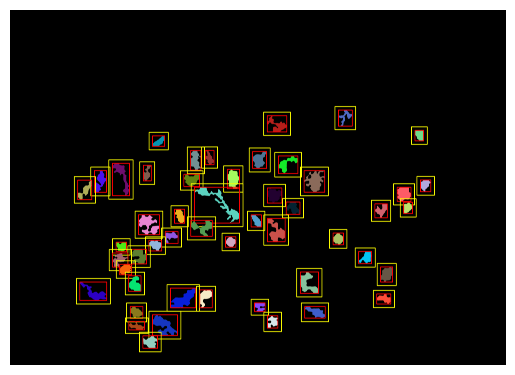

In [35]:
mpp = float(wsi.properties['openslide.mpp-x'])
roi_width = int(roi_width / float(mpp) / wsi_mask_ratio) 
bbx_map = bbx_overlay(epi_mask, bbx_pt, roi_width) 
plt.imshow(bbx_map)
plt.axis('off')

There're 50 ROIs detected


(-0.5, 6095.5, 5551.5, -0.5)

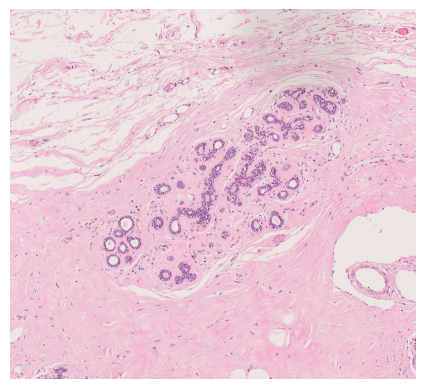

In [38]:
wsi_id = "17064108_FPE_1"
# get roi ids for all ROIs detected on the WSI
roi_ids = get_roi_ids(epi_mask, wsi_id, roi_width, wsi_mask_ratio)

## display a single ROI
im = show_roi(wsi, roi_ids[3])
plt.imshow(im)
plt.axis('off')

In [63]:
## save the JSON file
json_pt = f"/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_TC512_ROIdetection.json"

patch_df = save_patchcsv(roi_ids, patch_size, TC_maskpt, output_dir=None)
patch_df = addWSIxy(patch_df)
get_JSON(patch_df, cls_dict, json_pt, patch_size, require_bounds=False)

/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_TC512_ROIdetection.json saved!


## Tissue-specific patch selection for downstream WSI analysis

3000


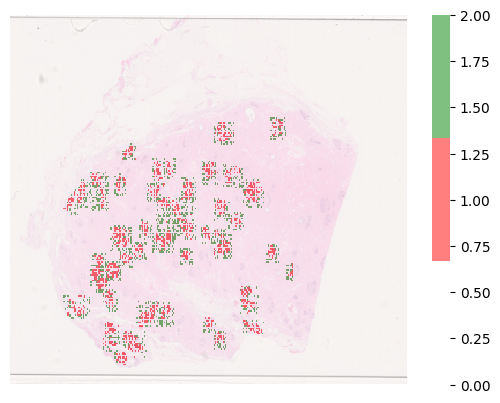

In [88]:
df = patch_df.copy()
counter = 0
num2sample = 1500
for cls in ["epithelium", "stroma"]:
    df_cls = df.loc[df["cls"] == cls,]
    df_cls = df_cls.sample(frac=1)
    df_cls = df_cls.iloc[:num2sample, :]
    if counter == 0:
        patch_sampled = df_cls
    else:
        patch_sampled = pd.concat([patch_sampled, df_cls])
    counter += 1
print(len(patch_sampled))

fig = overlay_patch_sampled(patch_sampled, wsi_pt, patch_size, save_folder)

### Alternatively, using TC_1024

(-0.5, 135.5, 96.5, -0.5)

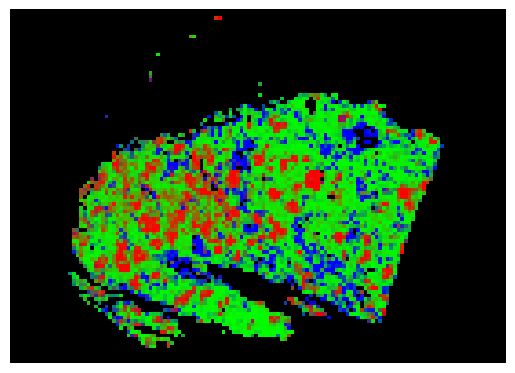

In [40]:
TC_1024 = get_TC1024()
tissue_map1024 = run_TC_one_slide(wsi, mask_pt, TC, output_pattern, patch_size=128, foreground_thes=0.7, mrxs=False)

plt.imshow(tissue_map1024)
plt.axis('off')